# Predicting Heart Disease for Patients with Atypical Angina (ATA) Symptoms


## Introduction
Heart disease is a disease that refers to several types of heart conditions, which is the main cause of death in the USA for most of racial and ethnic groups (1). The main risk factors for heart disease are high blood pressure, high blood cholesterol, smoking, and age. Some of the common heart disease symptoms are chest pain, irregular heartbeats (heart beats too fast or too slow or irregularly), Pain in the back, and shortness of breath. Moreover, chest pain has different classes such as Typical Angina (TA), Atypical Angina (ATA), Non-Anginal Pain (NAP), and Asymptomatic (ASY). Atypical Angina (ATA) chest pain is any chest pain that does not meet criteria for a common or obvious diagnosis (3), and 14% of ATA chest pain leads to heart disease. 

#### Question: 
   Can we use the Age, resting blood pressure (normal blood pressure when body is at rest), maximum heart rate achieved, and blood cholesterol level (provided by the dataset), to predict if a patient with ATA has heart disease? 
   
   To answer this question, we will use the “Heart Failure Prediction Dataset”. This dataset contains 11 variables, which Age, RestingBP, Cholesterol, MaxHR variables will be used to predict the heart disease status (1 = heart disease and 0 = normal). 


## Preliminary exploraty data analysis

In [ ]:
### Loading Libraries into R
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

In [11]:
#reading data, all columns included, no need for skipping 
#data is tidy 
data <- read_csv("data/heart.csv")
data <- data|>
        mutate(HeartDisease = as.factor(HeartDisease))
data

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


## Variable Explanation 

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

### Cleaning the data 
Filtering for ATA chest pain since we are interested in predicting the status of heart disease for patients with this symptom. Selecting for these following numerical variables: 
age, resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl)

In [12]:
data_cleaned <- data|>
        filter(ChestPainType== "ATA")|>
        select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)
data_cleaned

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
37,130,283,98,0
45,130,237,170,0
⋮,⋮,⋮,⋮,⋮
55,132,342,166,0
41,120,157,182,0
57,130,236,174,1


## Spliting data
spliting the data into training set and testing set, 75% of the data in the training set

In [5]:
### spliting the data into training set and testing set, 75% of the data in the training set
data_split <- initial_split(data_cleaned, prop = 0.75, strata = HeartDisease) 
data_train <- training(data_split)   
data_test <- testing(data_split)
data_train
data_test

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,283,98,0
45,130,237,170,0
54,110,208,142,0
⋮,⋮,⋮,⋮,⋮
54,192,283,195,1
58,120,284,160,1
57,130,236,174,1


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
39,120,204,145,0
54,120,273,150,0
⋮,⋮,⋮,⋮,⋮
56,140,294,153,0
57,154,232,164,1
35,122,192,174,0


## Table

In [6]:
na_heart <- data_train|>
        filter(HeartDisease=NA)|>
        group_by(HeartDisease)|>
        summarize(n=n())
na_heart

HeartDisease,n
<fct>,<int>


None of the rows have a missing data within our data set.

In [7]:
nheart <- data_train|>
        group_by(HeartDisease)|>
        summarize(Observation=n())

table_1 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, mean, na.rm=TRUE)) 
mean_heart_disease <- merge(table_1,nheart) |>
    rename(Avg_Age = Age, Avg_RestingBP = RestingBP, Avg_Cholesterol = Cholesterol, Avg_MaxHR = MaxHR)

table_2 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, max, na.rm=TRUE)) 
max_heart_disease <- merge(table_2, nheart) |>
    rename(max_Age = Age, max_RestingBP = RestingBP, max_Cholesterol = Cholesterol, max_MaxHR = MaxHR) 

table_3 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, min, na.rm=TRUE)) 
min_heart_disease <- merge(table_3, nheart) |>
    rename(min_Age = Age, min_RestingBP = RestingBP, min_Cholesterol = Cholesterol, min_MaxHR = MaxHR)

table_4 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, var, na.rm=TRUE)) 
variance_heart_disease <- merge(table_4,nheart) |>
    rename(var_Age = Age, var_RestingBP = RestingBP, var_Cholesterol = Cholesterol, var_MaxHR = MaxHR) 



mean_heart_disease
max_heart_disease
min_heart_disease
variance_heart_disease

HeartDisease,Avg_Age,Avg_RestingBP,Avg_Cholesterol,Avg_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,48.25225,129.2252,233.3333,151.8108,111
1,55.61111,143.7778,225.5000,137.6111,18


HeartDisease,max_Age,max_RestingBP,max_Cholesterol,max_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,70,190,468,192,111
1,74,192,393,195,18


HeartDisease,min_Age,min_RestingBP,min_Cholesterol,min_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,28,98,0,98,111
1,35,110,0,95,18


HeartDisease,var_Age,var_RestingBP,var_Cholesterol,var_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,76.09943,230.2852,4337.624,414.5366,111
1,88.72222,568.0654,12825.206,715.3105,18


## visalization 

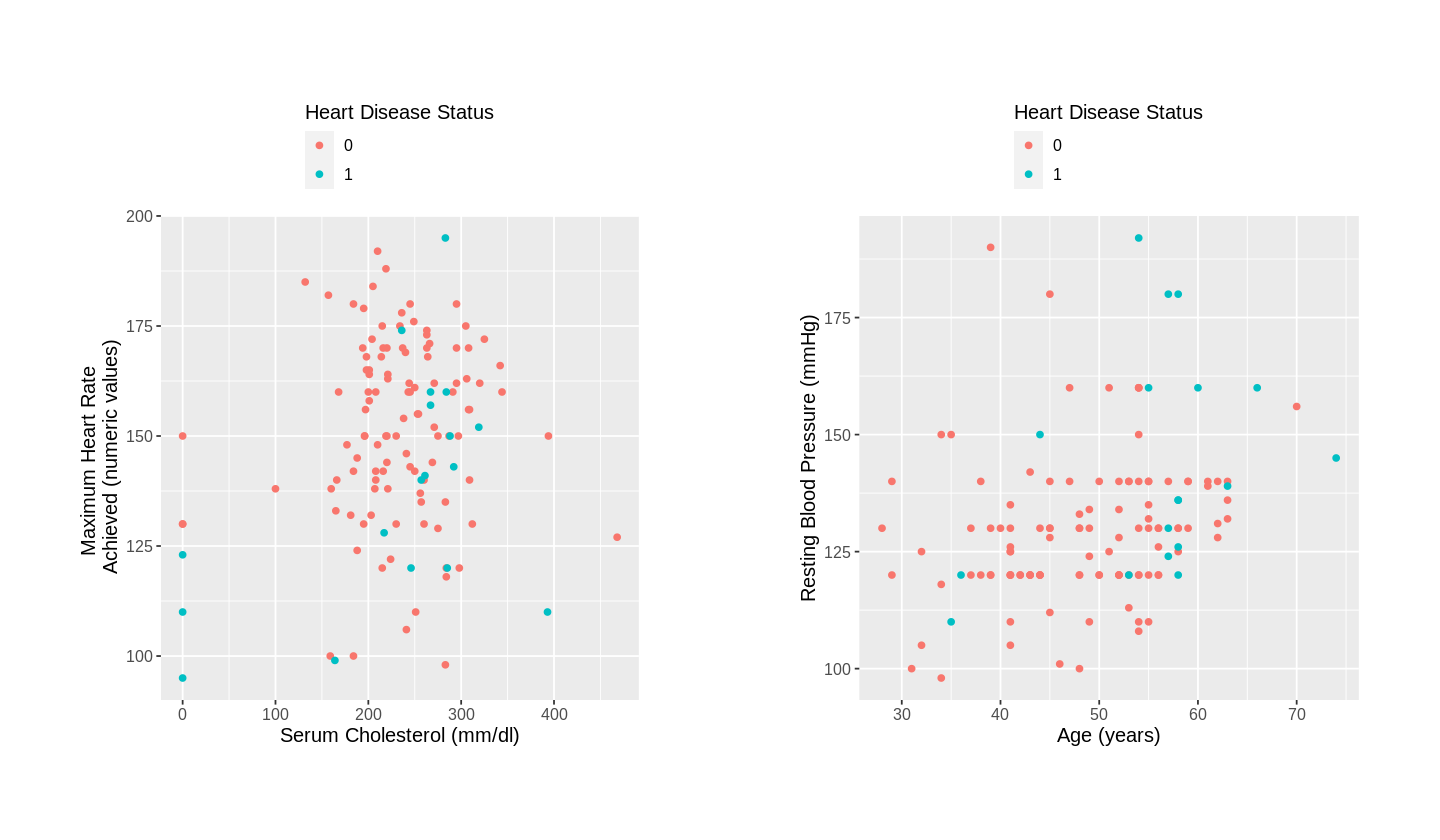

In [8]:
options(repr.plot.width = 12, repr.plot.height = 7) 

#scaterplot resting blood pressure and age 
agevsbp <- ggplot(data_train, aes(x = Age, y = RestingBP, color = HeartDisease)) +
      geom_point() +
      xlab("Age (years)") +
      ylab("Resting Blood Pressure (mmHg)") +
        labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 12),
        legend.position = "top",
        legend.direction = "vertical") 
      
#agevsbp

#scaterplot cholesterol level and max heart rate
cholvshr <- ggplot(data_train, aes(x = Cholesterol, y = MaxHR, color = HeartDisease)) +
      geom_point() +
      xlab("Serum Cholesterol (mm/dl)") +
      ylab("Maximum Heart Rate \n Achieved (numeric values)") +
labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 12),
        legend.position = "top",
        legend.direction = "vertical") 

#cholvshr
library(cowplot)
plot_grid(cholvshr, agevsbp, scale=0.8)

## Methods:
  In this project, we are using the “Heart Failure Prediction Dataset” and classification method to predict whether a person with atypical angina (ATA) chest pain has a heart disease or not. The classification method will be used because we want to predict heart disease status, which is a (binary) categorical variable, 1= “yes” or 0 = “no”. We will use the numerical variables (predictors) in the dataset including; age (years), resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl) for our prediction as these numerical variables are either the risk factors or symptoms for heart disease. 

We can plot the accuracy versus number of neighbors (k-value) to find the k value with the highest accuracy using a line graph. We can also generate a scatter plot with the scaled and centered age and resting blood pressure on the axis while differentiating the heart disease status with different colors. 

## Expected outcomes and significance:

By developing this model, we expect to be able to predict heart disease accurately based on the biological determinants observed in individuals. This model is particularly significant as it filters for the individuals with ATA chest pain. Chest pain with an atypical angina is not easily diagnosed or classified as a common or obvious condition. Therefore, our model can lay the groundwork for development of models that predict or diagnose heart disease in the patients with atypical pains. Also, in our analysis, some relationships may be observed between heart disease and the predictors. These observations can lead the researchers to answer further questions like what the physiological mechanisms behind these relationships are. Another significant question that will expand this work would be how we can design one model capable of predicting heart disease in individuals with different types of chest pains and across different genders.

## Refrences
1.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

2.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

3.Centers for Disease Control and Prevention, National Center for Health Statistics. About Multiple Cause of Death, 1999–2020. CDC WONDER Online Database website. Atlanta, GA: Centers for Disease Control and Prevention; 2022. Accessed February 21, 2022.

4.fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
